# Transfer learning / fine-tuning

Esse notebook foi elaborado com base no disponibilizado [aqui](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb).

## Procedimento

O primeiro passo é o carregamento das dependências necessárias, assim como obtenção e preparação do dataset escolhido para o projeto ([Kaggle Cats and Dogs](https://https://www.microsoft.com/en-us/download/details.aspx?id=54765)).


In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image, UnidentifiedImageError

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
!echo "Downloading Kaggle Cats and Dogs Dataset"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls

############################################################################################# 100.0%
 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


In [30]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


Dentro das pastas há alguns arquivos que não são imagens, portanto vamos removê-los.

In [4]:
for foldername, subfolders, filenames in os.walk(root):
    for filename in filenames:
        if not filename.lower().endswith('.jpg'):
            file_path = os.path.join(foldername, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

for filename in os.listdir(root):
    file_path = os.path.join(root, filename)
    if os.path.isfile(file_path) and not filename.lower().endswith('.jpg'):
        os.remove(file_path)
        print(f"Deleted: {file_path}")

Deleted: PetImages/Dog/Thumbs.db
Deleted: PetImages/Cat/Thumbs.db


Optou-se por renomear os arquivos.

In [5]:
def rename_files_in_subfolder(subfolder_path, prefix):
    files = sorted(os.listdir(subfolder_path))

    for index, file_name in enumerate(files, start=1):
        new_name = f"{prefix}_{index:06d}.jpg"
        old_path = os.path.join(subfolder_path, file_name)
        new_path = os.path.join(subfolder_path, new_name)

        os.rename(old_path, new_path)

cats_folder = os.path.join(root, 'Cat')
rename_files_in_subfolder(cats_folder, 'Cat')

dogs_folder = os.path.join(root, 'Dog')
rename_files_in_subfolder(dogs_folder, 'Dog')

Abaixo encontram-se duas funções auxiliares, a primeira dedicada ao pré-processamento das imagens, e a segunda para validação da integridade das imagens e exclusão de arquivos problemáticos.

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# helper function to validate integrity of images
def validate_images(root_folder, valid_extensions=['.jpg', '.png', '.jpeg']):
    valid_images = []
    error_log = []

    for dp, dn, filenames in os.walk(root_folder):
        for f in filenames:
            img_path = os.path.join(dp, f)
            if os.path.splitext(f)[1].lower() not in valid_extensions:
                continue
            try:
                with Image.open(img_path) as img:
                    img.verify()
                valid_images.append(img_path)
            except Exception as e:
                error_log.append(f"Invalid image file: {img_path} - Error: {e}")
                os.remove(img_path)

    print(error_log)

    return valid_images

Execução da função de validação e exclusão de imagens problemáticas.

In [7]:
valid_images = validate_images(root)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


["Invalid image file: PetImages/Dog/Dog_001896.jpg - Error: cannot identify image file '/content/PetImages/Dog/Dog_001896.jpg'", "Invalid image file: PetImages/Cat/Cat_008791.jpg - Error: cannot identify image file '/content/PetImages/Cat/Cat_008791.jpg'"]


De forma a atender às limitações de capacidade computacional do Colab em sua versão gratuita, aleatorizaram-se e selecionaram-se 2500 imagens de cada categoria.

In [8]:
def random_selection_and_cleanup(root_folder, num_to_keep):
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        if os.path.isdir(subfolder_path):
            files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]

            random.shuffle(files)
            files_to_keep = files[:num_to_keep]
            files_to_remove = files[num_to_keep:]

            for file_name in files_to_remove:
                file_path = os.path.join(subfolder_path, file_name)
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

            print(f"Kept {len(files_to_keep)} images in {subfolder_path}.")

In [9]:
random_selection_and_cleanup(root, num_to_keep=2500)

Kept 2500 images in PetImages/Dog.
Kept 2500 images in PetImages/Cat.


Carregamento e pré-processamento das imagens da pasta root.

In [10]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Nova aleatorização dos arquivos e separação dos conjuntos de treino, validação e teste (70%, 15%, 15%).

In [11]:
random.shuffle(data)

In [12]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separação dos dados e labels.

In [13]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 

Pré-processamento garantindo que os dados sejam do tipo float32 e normalizados entre 0 e 1.

In [14]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(750, 2)


Resumo:

In [15]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 5000 images from 2 categories
train / validation / test split: 3500, 750, 750
training data shape:  (3500, 224, 224, 3)
training labels shape:  (3500, 2)


Observação de algumas imagens aleatórias do conjunto:

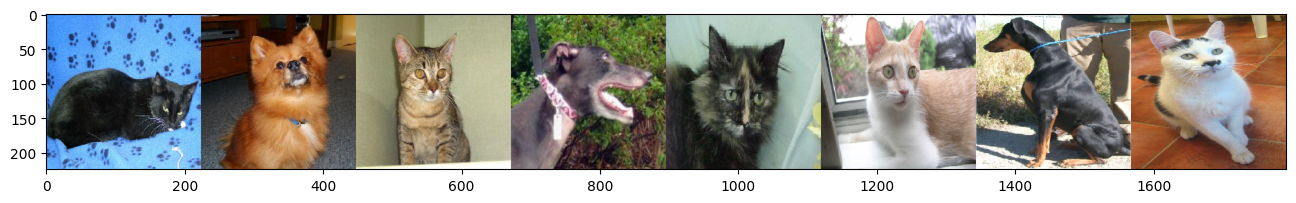

In [16]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Criação de uma RNA para comparação

Trecho traduzido do notebook original:

>A rede que iremos construir contém 4 camadas alternadas de convolução e max-pooling, seguidas por uma camada de [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada par de camadas de convolução/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada (fully connected) com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

>Nossa função de perda será, como de costume, a perda de entropia cruzada categórica (categorical cross-entropy), e nosso algoritmo de aprendizado será o [AdaDelta](https://arxiv.org/abs/1212.5701). Vários aspectos dessa rede podem ser alterados para obter um desempenho melhor — talvez usar uma rede maior ou um otimizador diferente ajude —, mas, para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação. Portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

>Após compilar a rede, vamos executar `model.summary()` para obter uma visão geral de suas camadas.

In [17]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

>O resultado é uma rede de tamanho médio com ~1.2 milhões de parâmetros.

>Agora podemos prosseguir e treinar nosso modelo em 10 épocas com um batch size de 128. Também registraremos o histórico do treinamento para que possamos plotar a perda ao longo do tempo posteriormente.

In [18]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 754ms/step - accuracy: 0.5208 - loss: 0.6888 - val_accuracy: 0.5987 - val_loss: 0.6450
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.6167 - loss: 0.6341 - val_accuracy: 0.6427 - val_loss: 0.6244
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6580 - loss: 0.6035 - val_accuracy: 0.6560 - val_loss: 0.6102
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.6613 - loss: 0.5891 - val_accuracy: 0.7053 - val_loss: 0.5701
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7172 - loss: 0.5432 - val_accuracy: 0.7093 - val_loss: 0.5623
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7529 - loss: 0.5094 - val_accuracy: 0.7213 - val_loss: 0.5652
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7413 - loss: 0.5065 - val_accuracy: 0.7147 - val_loss: 0.5455
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7617 - loss: 0.4969 - val_accuracy: 

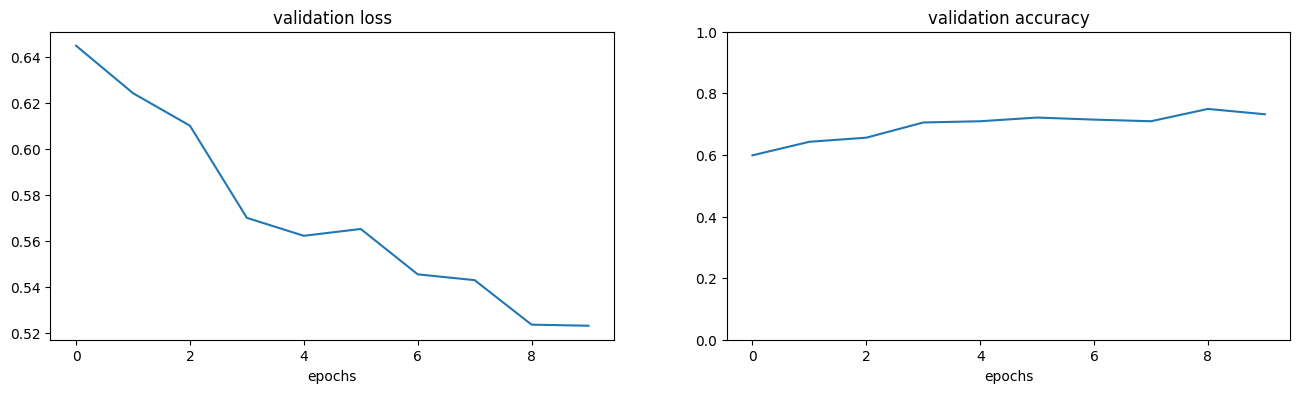

In [20]:
# plotting loss and accuracy
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Avaliando o resultado final da nossa rede:

In [21]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5210202932357788
Test accuracy: 0.734666645526886


Destaca-se que para esse conjunto de dados, de duas categorias, mesmo uma rede relativamente modesta já foi capaz de alcançar uma acurácia respeitável de mais de 70%.

## Transfer learning

A rede utilizada, como sugerido no notebook original, será a VGG16 do keras, treinada sobre ImageNet.

In [22]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

A rede é ajustada de forma a estabelecer uma nova camada final de classificação, com número de categorias correspondente ao nosso novo banco de dados.

Após, congelam-se os parâmetros de todas as outras camadas, para utilização do método de transfer learning, sem fine tuning. Por fim, compilamos o modelo com as mesmas configurações da nossa rede, e avaliamos o resultado.

In [23]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [24]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

O resultado continua sendo uma rede grande, com mais de 134 milhões de parâmetros, mas apenas 8194 deles são treináveis, considerando os dois neurônios da última camada para o conjunto de dados Cats and Dogs.

Seguimos com o treinamento do modelo, com os mesmos hiperparâmetros e algoritmo de otimização utilizados em nossa rede.



In [25]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.5666 - loss: 0.7938 - val_accuracy: 0.8200 - val_loss: 0.4409
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 716ms/step - accuracy: 0.8582 - loss: 0.4042 - val_accuracy: 0.8693 - val_loss: 0.3531
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 719ms/step - accuracy: 0.8790 - loss: 0.3385 - val_accuracy: 0.8720 - val_loss: 0.3195
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 777ms/step - accuracy: 0.8872 - loss: 0.3022 - val_accuracy: 0.8800 - val_loss: 0.2972
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.8967 - loss: 0.2770 - val_accuracy: 0.8707 - val_loss: 0.2998
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 779ms/step - accuracy: 0.8908 - loss: 0.2644 - val_accuracy: 0.8853 - val_loss: 0.2764
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 776ms/step - accuracy: 0.9026 - loss: 0.2609 - val_accuracy: 0.8893 - val_loss: 0.2555
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 774ms/step - accuracy: 0.9120 - loss: 0.2390 - val_accura

Conseguimos atingir uma acurácia de 90%!

Plotando a perda e acurácia, podemos comparar o novo modelo (em verde) com o modelo original (em azul).

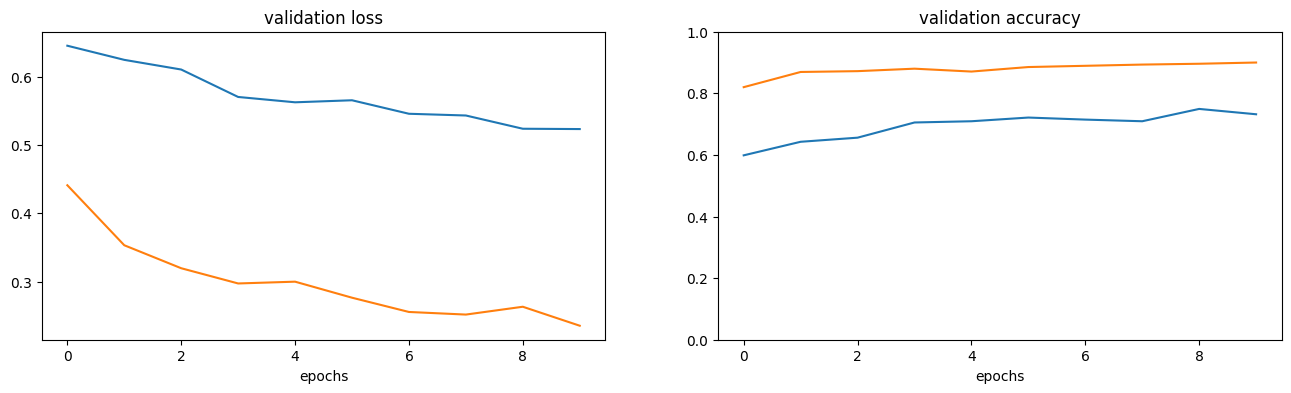

In [26]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Realizando a validação final, no conjunto de teste:

In [27]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.210612490773201
Test accuracy: 0.9160000085830688


To predict a new image, simply run the following code to get the probabilities for each class.

Selected file for testing: PetImages/Cat/Cat_007481.jpg


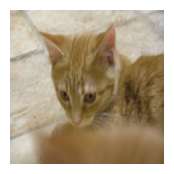

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PetImages/Dog: 0%
PetImages/Cat: 100%


In [92]:
def get_random_file(root_folder):
    files = []
    for dp, dn, filenames in os.walk(root_folder):
        for f in filenames:
            if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']:
                files.append(os.path.join(dp, f))
    return random.choice(files) if files else None

random_file = get_random_file(root)

print(f"Selected file for testing: {random_file}")

img, x = get_image(random_file)

plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

probabilities = model_new.predict([x])

for category, probability in zip(categories, probabilities[0]):
    print(f"{category}: {probability*100:.0f}%")
